# TeamMoodAnalysis
Notebook to explore ways to use previous match rating data

In [1]:
import os
from working_dir import set_wd
set_wd()
os.getcwd()

'/Users/tales.pimentel/ds/kaggle/football-match-prediction'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TeamMoodAnalysis").getOrCreate()

In [3]:
import pyspark.sql.functions as f
from pyspark.sql.functions import when
import matplotlib.pyplot as plt

from src.dao import dao_raw, dao_interim, columns
from src.utils import dflib, stats, pretties, plot, palette

In [4]:
pretties.max_data_frame_columns()

In [5]:
COLOR_HOME = palette.PALETTE_TARGET["home"]
COLOR_DRAW = palette.PALETTE_TARGET["draw"]
COLOR_AWAY = palette.PALETTE_TARGET["away"]

# Loading Data

In [6]:
ttrain = dao_interim.load_train_train_data(spark)
scores = dao_raw.load_parse_scores_data(spark)

drop_cols = columns.team_history_coach_colnames + \
            columns.team_history_is_cup_cols + \
            columns.team_history_is_play_home_cols + \
            columns.team_history_match_date_cols + \
            columns.team_history_league_id_cols + \
            columns.team_history_goal_cols

ttrain = ttrain.drop(*drop_cols)

print(f"ttrain: {dflib.shape(ttrain)}")
print(f"scores: {dflib.shape(scores)}")

ttrain: (87470, 50)
scores: (110938, 3)


In [7]:
ttrain = scores.select(["id", "score"]).join(ttrain, on="id", how="inner")
print(f"train: {dflib.shape(ttrain)}")

train: (87470, 51)


In [8]:
basic_cols = ['id', 'score', 'target', 'home_team_name', 'away_team_name', 
              'match_date', 'league_name', 'league_id', 'is_cup']

# Team Match Mood

## team_history_mood
Difference between history_rating_n and history_opponent_rating_n.

In [9]:
for which_team in ["home", "away"]:

    for i in range(1, 11):
        team_history_mood = f"{which_team}_history_mood_{i}"
        team_history_rating = f"{which_team}_team_history_rating_{i}"
        opponent_history_rating = f"{which_team}_team_history_opponent_rating_{i}"
        
        ttrain = ttrain.withColumn(team_history_mood, 
                                          ttrain[team_history_rating] - \
                                          ttrain[opponent_history_rating])

Validating

In [10]:
ttrain.limit(3).select(["home_history_mood_5", 
                        "home_team_history_rating_5", 
                        "home_team_history_opponent_rating_5",
                        "away_history_mood_9", 
                        "away_team_history_rating_9", 
                        "away_team_history_opponent_rating_9"]).toPandas()

,home_history_mood_5,home_team_history_rating_5,home_team_history_opponent_rating_5,away_history_mood_9,away_team_history_rating_9,away_team_history_opponent_rating_9
0,1.398131,5.478300000000001,4.080169230769231,7.913075,10.970814285714287,3.057739285714285
1,3.685993,7.804064285714285,4.1180714285714295,-3.834623,4.1258423076923085,7.960465384615384
2,-3.912490,3.8643600000000005,7.7768500000000005,1.151759,6.45101875,5.299259374999999


In [11]:
print(dflib.shape(ttrain))
ttrain = ttrain.drop(*columns.team_history_rating_cols)
print(dflib.shape(ttrain))

(87470, 71)
(87470, 31)


## team_history_mood_mean
Mean of previous (historical) team_history_mood_n.

In [12]:
home_history_mood_colnames = [f"home_history_mood_{i}" for i in range(1, 11)]
home_match_mood_numeric = stats.row_mean(df=ttrain, colnames=home_history_mood_colnames, 
                                         row_mean_colname="home_history_mood_mean", 
                                         index_colname="id")

away_history_mood_colnames = [f"away_history_mood_{i}" for i in range(1, 11)]
away_match_mood_numeric = stats.row_mean(df=ttrain, colnames=away_history_mood_colnames, 
                                         row_mean_colname="away_history_mood_mean", 
                                         index_colname="id")

ttrain = ttrain.join(home_match_mood_numeric, on="id", how="left")
ttrain = ttrain.join(away_match_mood_numeric, on="id", how="left")

In [13]:
# print(dflib.shape(ttrain))
# stats.describe_cols(ttrain, ["home_match_mood_numeric", "away_match_mood_numeric"], 4).show()

In [14]:
# plot.hist(ttrain, "home_match_mood_numeric", bins=30, figsize=(6, 2))
# plot.hist(ttrain, "away_match_mood_numeric", bins=30, figsize=(6, 2))

Validating

In [15]:
display(ttrain.limit(3).select(["home_history_mood_mean"] + home_history_mood_colnames).toPandas())
display(ttrain.filter(ttrain["home_history_mood_10"].isNull()).limit(3).select(["home_history_mood_mean"] + home_history_mood_colnames).toPandas())

,home_history_mood_mean,home_history_mood_1,home_history_mood_2,home_history_mood_3,home_history_mood_4,home_history_mood_5,home_history_mood_6,home_history_mood_7,home_history_mood_8,home_history_mood_9,home_history_mood_10
0,1.634704,3.283155,-0.321671,-0.502561,-4.279150,5.556073,1.918392,-0.916111,-0.902963,12.770750,-0.258870
1,-1.488365,-7.276695,-0.736394,-4.952425,0.662473,-2.908779,-3.451164,1.970667,0.761820,-3.737857,4.784707
2,0.996628,0.340983,0.512602,4.810275,-0.950104,-0.117811,0.141100,2.915550,-0.709112,3.036450,-0.013650


,home_history_mood_mean,home_history_mood_1,home_history_mood_2,home_history_mood_3,home_history_mood_4,home_history_mood_5,home_history_mood_6,home_history_mood_7,home_history_mood_8,home_history_mood_9,home_history_mood_10
0,-1.715054,-4.443050,3.953683,1.62030,-7.991150,NaN,NaN,NaN,NaN,NaN,NaN
1,-6.903041,-4.019617,-5.887414,-9.25635,-8.448783,NaN,NaN,NaN,NaN,NaN,NaN
2,5.554536,7.547417,8.790572,-2.53655,8.448783,12.900944,-1.82395,NaN,NaN,NaN,NaN


## team_mood_diff
Diference between home_team and away_team match_mood_numeric.

In [16]:
ttrain = ttrain.withColumn("home_mood_diff", f.col("home_history_mood_mean") - f.col("away_history_mood_mean"))
ttrain = ttrain.withColumn("away_mood_diff", f.col("away_history_mood_mean") - f.col("home_history_mood_mean"))

In [17]:
print(dflib.shape(ttrain))
stats.describe_cols(ttrain, ["home_mood_diff", "away_mood_diff"], 4).show()

(87470, 35)
+------+-----+------+----+-----+-----+--------------+
|   min| q_25|median|q_75|  max| mean|        column|
+------+-----+------+----+-----+-----+--------------+
|-51.59|-2.01| -0.06| 1.9|53.27|-0.04|home_mood_diff|
|-53.27| -1.9|  0.06|2.01|51.59| 0.04|away_mood_diff|
+------+-----+------+----+-----+-----+--------------+



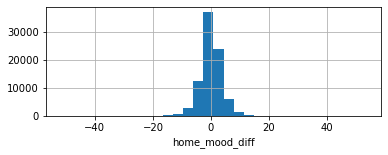

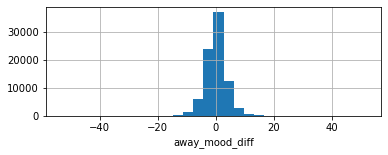

In [18]:
plot.hist(ttrain, "home_mood_diff", bins=30, figsize=(6, 2))
plot.hist(ttrain, "away_mood_diff", bins=30, figsize=(6, 2))

Validating

In [19]:
display(ttrain.limit(3).select(["home_mood_diff", "home_history_mood_mean", "away_history_mood_mean"]).toPandas())

,home_mood_diff,home_history_mood_mean,away_history_mood_mean
0,-1.003665,1.634704,2.638369
1,0.873839,-1.488365,-2.362204
2,1.148099,0.996628,-0.151471


## team_mood
Mapping team_mood_diff to team_mood.
 * OPTIMISTIC: team_mood_diff > 0
 * PESSIMISTIC: team_mood_diff > 0
 * NEUTRAL: team_mood_diff 'close' to 0
   * Please check MOOD_NUMERIC_THRESHOLD for 'close' numeric definition

In [20]:
split_score = f.split(ttrain['score'], "-")
ttrain = ttrain.withColumn('home_goals', split_score.getItem(0))
ttrain = ttrain.withColumn('away_goals', split_score.getItem(1))

In [21]:
MOOD_NUMERIC_THRESHOLD = 0.25

ttrain = ttrain.withColumn("home_mood", 
                                      f.when(f.abs(ttrain["home_mood_diff"]) < MOOD_NUMERIC_THRESHOLD, "NEUTRAL") \
                           .otherwise(f.when(ttrain["home_mood_diff"] < 0, "PESSIMISTIC") \
                           .otherwise(f.when(ttrain["home_mood_diff"] > 0, "OPTIMISTIC"))))

ttrain = ttrain.withColumn("away_mood", 
                                      f.when(f.abs(ttrain["away_mood_diff"]) < MOOD_NUMERIC_THRESHOLD, "NEUTRAL")\
                           .otherwise(f.when(ttrain["away_mood_diff"] < 0, "PESSIMISTIC") \
                           .otherwise(f.when(ttrain["away_mood_diff"] > 0, "OPTIMISTIC"))))

In [22]:
stats.freq(ttrain, "home_mood").show()
stats.freq(ttrain, "away_mood").show()

+-----------+--------+--------------------+
|  home_mood|Absolute|            Relative|
+-----------+--------+--------------------+
| OPTIMISTIC|   38997| 0.44583285697953584|
|    NEUTRAL|    6215| 0.07105293243397737|
|PESSIMISTIC|   40467|  0.4626386189550703|
|       null|    1791|0.020475591631416486|
+-----------+--------+--------------------+

+-----------+--------+--------------------+
|  away_mood|Absolute|            Relative|
+-----------+--------+--------------------+
| OPTIMISTIC|   40467|  0.4626386189550703|
|    NEUTRAL|    6215| 0.07105293243397737|
|PESSIMISTIC|   38997| 0.44583285697953584|
|       null|    1791|0.020475591631416486|
+-----------+--------+--------------------+



Validating

In [23]:
display(ttrain.filter(ttrain["home_mood"] == "OPTIMISTIC").limit(2).select(["home_mood", "away_mood", "home_mood_diff", "away_mood_diff"]).toPandas())
display(ttrain.filter(ttrain["home_mood"] == "NEUTRAL").limit(2).select(["home_mood", "away_mood", "home_mood_diff", "away_mood_diff"]).toPandas())
display(ttrain.filter(ttrain["home_mood"] == "PESSIMISTIC").limit(2).select(["home_mood", "away_mood", "home_mood_diff", "away_mood_diff"]).toPandas())

,home_mood,away_mood,home_mood_diff,away_mood_diff
0,OPTIMISTIC,PESSIMISTIC,1.567881,-1.567881
1,OPTIMISTIC,PESSIMISTIC,0.286281,-0.286281


,home_mood,away_mood,home_mood_diff,away_mood_diff
0,NEUTRAL,NEUTRAL,0.021316,-0.021316
1,NEUTRAL,NEUTRAL,-0.022292,0.022292


,home_mood,away_mood,home_mood_diff,away_mood_diff
0,PESSIMISTIC,OPTIMISTIC,-1.455834,1.455834
1,PESSIMISTIC,OPTIMISTIC,-6.622155,6.622155


## result
The match result.

In [24]:
ttrain = ttrain.withColumn("result", ttrain["home_goals"] - ttrain["away_goals"])
ttrain = ttrain.withColumn("result", f.when(ttrain["result"] > 0, "HOME").otherwise(f.when(ttrain["result"] < 0, "AWAY").otherwise(f.lit("DRAW"))))

In [25]:
cols_analysis = ["id", "home_goals", "away_goals", "result", "home_mood", "away_mood", "home_mood_diff", "away_mood_diff", "home_history_mood_mean", "away_history_mood_mean"]
team_mood_df = ttrain.select(cols_analysis)

In [26]:
df = team_mood_df.toPandas()
df.head(10)

,id,home_goals,away_goals,result,home_mood,away_mood,home_mood_diff,away_mood_diff,home_history_mood_mean,away_history_mood_mean
0,11428297,0,0,DRAW,PESSIMISTIC,OPTIMISTIC,-1.455834,1.455834,-1.785747,-0.329913
1,11428298,1,4,AWAY,PESSIMISTIC,OPTIMISTIC,-6.622155,6.622155,-1.477630,5.144525
2,11428302,4,2,HOME,OPTIMISTIC,PESSIMISTIC,1.567881,-1.567881,-0.391154,-1.959036
3,11428303,1,1,DRAW,OPTIMISTIC,PESSIMISTIC,0.765143,-0.765143,-0.921668,-1.686812
4,11428308,1,1,DRAW,PESSIMISTIC,OPTIMISTIC,-3.642649,3.642649,-1.522024,2.120625
5,11428311,0,4,AWAY,PESSIMISTIC,OPTIMISTIC,-5.618006,5.618006,-0.208806,5.409200
6,11438042,3,2,HOME,OPTIMISTIC,PESSIMISTIC,0.286281,-0.286281,-0.181791,-0.468072
7,11438045,4,1,HOME,PESSIMISTIC,OPTIMISTIC,-3.436788,3.436788,-1.137122,2.299665
8,11438047,1,1,DRAW,PESSIMISTIC,OPTIMISTIC,-0.968794,0.968794,-2.254913,-1.286119
9,11438048,0,0,DRAW,PESSIMISTIC,OPTIMISTIC,-2.989200,2.989200,-1.661700,1.327500


# Analysis

### Checking frequencies

In [27]:
print("result")
stats.freq(team_mood_df, "result", round_n=4).show()
print("home_mood")
stats.freq(team_mood_df, "home_mood", round_n=4).show()
print("away_mood")
stats.freq(team_mood_df, "away_mood", round_n=4).show()

result
+------+--------+--------+
|result|Absolute|Relative|
+------+--------+--------+
|  AWAY|   27799|  0.3178|
|  HOME|   38109|  0.4357|
|  DRAW|   21562|  0.2465|
+------+--------+--------+

home_mood
+-----------+--------+--------+
|  home_mood|Absolute|Relative|
+-----------+--------+--------+
| OPTIMISTIC|   38997|  0.4458|
|    NEUTRAL|    6215|  0.0711|
|PESSIMISTIC|   40467|  0.4626|
|       null|    1791|  0.0205|
+-----------+--------+--------+

away_mood
+-----------+--------+--------+
|  away_mood|Absolute|Relative|
+-----------+--------+--------+
| OPTIMISTIC|   40467|  0.4626|
|    NEUTRAL|    6215|  0.0711|
|PESSIMISTIC|   38997|  0.4458|
|       null|    1791|  0.0205|
+-----------+--------+--------+



In [28]:
home_results = stats.groupby_freq(df=team_mood_df, groupby_cols=["home_mood"], freq_on_col="result", round_n=4)\
    .orderBy(when(f.col("home_mood") == "OPTIMISTIC", 1).when(f.col("home_mood") == "NEUTRAL", 2).when(f.col("home_mood") == "PESSIMISTIC", 3).when(f.col("home_mood") == "NULL", 4))

away_results = stats.groupby_freq(df=team_mood_df, groupby_cols=["away_mood"], freq_on_col="result", round_n=4)\
    .orderBy(when(f.col("away_mood") == "OPTIMISTIC", 1).when(f.col("away_mood") == "NEUTRAL", 2).when(f.col("away_mood") == "PESSIMISTIC", 3).when(f.col("away_mood") == "NULL", 4))

home_results.show()

+-----------+------+--------+--------+
|  home_mood|result|Absolute|Relative|
+-----------+------+--------+--------+
| OPTIMISTIC|  HOME|   21419|  0.5492|
| OPTIMISTIC|  AWAY|    8538|  0.2189|
| OPTIMISTIC|  DRAW|    9040|  0.2318|
|    NEUTRAL|  DRAW|    1792|  0.2883|
|    NEUTRAL|  HOME|    2606|  0.4193|
|    NEUTRAL|  AWAY|    1817|  0.2924|
|PESSIMISTIC|  DRAW|   10374|  0.2564|
|PESSIMISTIC|  HOME|   13231|   0.327|
|PESSIMISTIC|  AWAY|   16862|  0.4167|
|       NULL|  AWAY|     582|   0.325|
|       NULL|  HOME|     853|  0.4763|
|       NULL|  DRAW|     356|  0.1988|
+-----------+------+--------+--------+



In [29]:
home_results_piv = home_results.groupBy("home_mood").pivot("result").sum("Relative")
away_results_piv = away_results.groupBy("away_mood").pivot("result").sum("Relative")

home_results_piv.show(truncate=False)

+-----------+------+------+------+
|home_mood  |AWAY  |DRAW  |HOME  |
+-----------+------+------+------+
|OPTIMISTIC |0.2189|0.2318|0.5492|
|NEUTRAL    |0.2924|0.2883|0.4193|
|PESSIMISTIC|0.4167|0.2564|0.327 |
|NULL       |0.325 |0.1988|0.4763|
+-----------+------+------+------+



In [30]:
home_mood_diff_result = team_mood_df.groupBy("result").agg(f.percentile_approx("home_mood_diff", 0.50).alias("team_mood_diff_median"))
away_mood_diff_result = team_mood_df.groupBy("result").agg(f.percentile_approx("away_mood_diff", 0.50).alias("team_mood_diff_median"))

### Checking team_mood_diff over match results 

HOME
+------+---------------------+
|result|team_mood_diff_median|
+------+---------------------+
|  AWAY|              -1.1006|
|  HOME|               0.7767|
|  DRAW|              -0.1845|
+------+---------------------+



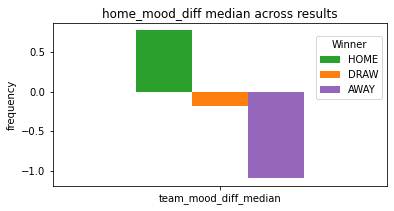

AWAY
+------+---------------------+
|result|team_mood_diff_median|
+------+---------------------+
|  AWAY|               1.1005|
|  HOME|               -0.778|
|  DRAW|               0.1839|
+------+---------------------+



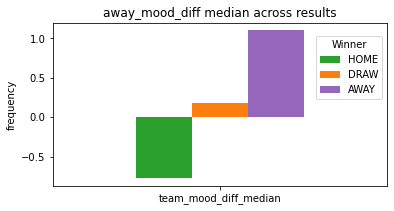

In [31]:
print("HOME")
dflib.round_cols(home_mood_diff_result, ["team_mood_diff_median"], 4).show()
ax1 = home_mood_diff_result.toPandas().set_index("result").loc[["HOME", "DRAW", "AWAY"]].transpose().plot.bar(title="home_mood_diff median across results", color=[COLOR_HOME, COLOR_DRAW, COLOR_AWAY], figsize=(6,3), rot=0)
ax1.legend(title="Winner", bbox_to_anchor=(1.0, 0.95))
ax1.set_ylabel("frequency")
plt.show()
pretties.hr()
print("AWAY")
dflib.round_cols(away_mood_diff_result, ["team_mood_diff_median"], 4).show()
ax2 = away_mood_diff_result.toPandas().set_index("result").loc[["HOME", "DRAW", "AWAY"]].transpose().plot.bar(title="away_mood_diff median across results", color=[COLOR_HOME, COLOR_DRAW, COLOR_AWAY], figsize=(6,3), rot=0)
ax2.legend(title="Winner", bbox_to_anchor=(1.0, 0.95))
ax2.set_ylabel("frequency")
plt.show()

#### Notes
As the plot shows, the median of `team_mood_diff` seems to give a good clue about the match result for both HOME and AWAY teams.

In [32]:
team_mood_hist_df = team_mood_df.filter((f.col("home_mood_diff").isNotNull()) & (f.abs("home_mood_diff") < 15))

values_result_home = [int(row.home_mood_diff) for row in team_mood_hist_df.filter((f.col("result") == "HOME") & (f.col("home_mood_diff").isNotNull())).select(["home_mood_diff"]).collect()]
values_result_draw = [int(row.home_mood_diff) for row in team_mood_hist_df.filter((f.col("result") == "DRAW") & (f.col("home_mood_diff").isNotNull())).select(["home_mood_diff"]).collect()]
values_result_away = [int(row.home_mood_diff) for row in team_mood_hist_df.filter((f.col("result") == "AWAY") & (f.col("home_mood_diff").isNotNull())).select(["home_mood_diff"]).collect()]

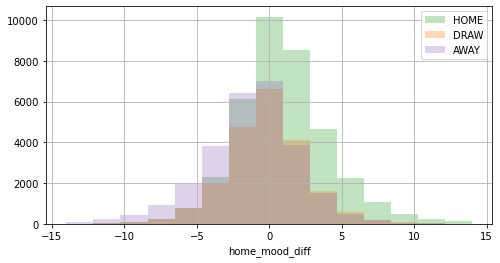

In [33]:
plt.figure(figsize=(8,4))

plt.hist(values_result_home, bins=15, alpha=0.3, label="HOME", color=COLOR_HOME)
plt.hist(values_result_draw, bins=15, alpha=0.3, label="DRAW", color=COLOR_DRAW)
plt.hist(values_result_away, bins=15, alpha=0.3, label="AWAY", color=COLOR_AWAY)

plt.grid(zorder=0)
plt.xlabel("home_mood_diff")
plt.legend()
plt.show()

#### Notes
The boxplot distribution were difficult to interpret. <br>
These histograms shows that, despite the huge overlapping area, it is possible to split some match results with the `home_mood_diff`. <br>
Of course this new feature alone will lead to a grate performance. It need more potential good features.

### Checking winner frequencies over team_mood_diff

,home_mood,AWAY,DRAW,HOME
0,OPTIMISTIC,0.2189,0.2318,0.5492
1,NEUTRAL,0.2924,0.2883,0.4193
2,PESSIMISTIC,0.4167,0.2564,0.3270
3,NULL,0.3250,0.1988,0.4763


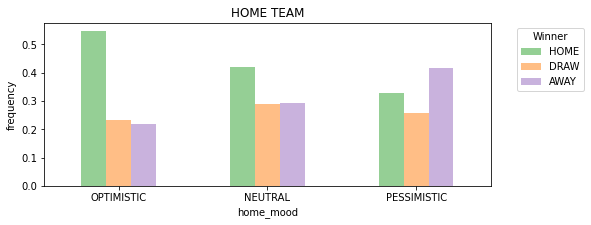

,away_mood,AWAY,DRAW,HOME
0,OPTIMISTIC,0.4167,0.2564,0.3270
1,NEUTRAL,0.2924,0.2883,0.4193
2,PESSIMISTIC,0.2189,0.2318,0.5492
3,NULL,0.3250,0.1988,0.4763


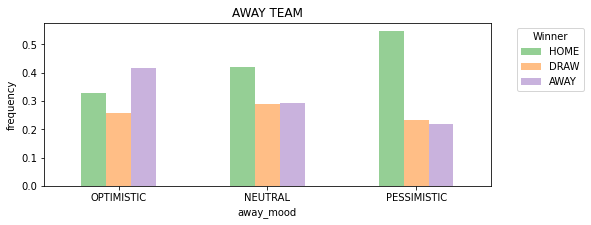

In [34]:
display(home_results_piv.toPandas())
ax1 = home_results_piv.toPandas().set_index("home_mood").loc[["OPTIMISTIC", "NEUTRAL", "PESSIMISTIC"]][["HOME", "DRAW", "AWAY"]].plot.bar(title="HOME TEAM", color=[COLOR_HOME, COLOR_DRAW, COLOR_AWAY], rot=0, alpha=0.5, figsize=(8,3))
ax1.legend(title="Winner", bbox_to_anchor=(1.22, 1))
ax1.set_ylabel("frequency")
plt.show()
print()
display(away_results_piv.toPandas())
ax2 = away_results_piv.toPandas().set_index("away_mood").loc[["OPTIMISTIC", "NEUTRAL", "PESSIMISTIC"]][["HOME", "DRAW", "AWAY"]].plot.bar(title="AWAY TEAM", color=[COLOR_HOME, COLOR_DRAW, COLOR_AWAY], rot=0, alpha=0.5, figsize=(8,3))
ax2.legend(title="Winner", bbox_to_anchor=(1.22, 1))
ax2.set_ylabel("frequency")
plt.show()

#### Notes
Checking the winner (`result`) frequencies over the categorical team_mood we can see that teams playing HOME with OPTIMISTIC team_mood have won more often. <br>
Another interesting thing to note is that even the team playing HOME, if it is PESSIMISTIC, the AWAY team is more likeli to win.

# Conclusions

It seems that the team_mood_diff (`home_mood_diff` and `away_mood_diff`) are good potential features along with their categorical representations (`home_mood` and `away_mood`). <br>